# Leaderboard update - TOP 50% !!!
Funny thing... this notebook that does a very simple random forest with no feature engineering, or hyperparamater tuning at all, shot way up the leaderboard from bottom 75% in the public version, to top 50% in the private version!!

Just a pretty good lesson that doing a simple random forest should probably be the first thing that you do, and makes for a pretty good baseline for most structured data tasks.

# Overview of this notebook! <img src = "https://upload.wikimedia.org/wikipedia/commons/d/d1/HerdQuit.jpg" align = "right" width = 300 alt="Wrangling">

### 1. Unpivot
The format of the data provided in this contest is not so great for data science! In order to get the historic data in the format that a model can use to make predictions requires a lot of wrangling. 

The given layout of the data is that each product/store combination is a row, and each date is a column (going out to 1900+ date columns...). It look like this:
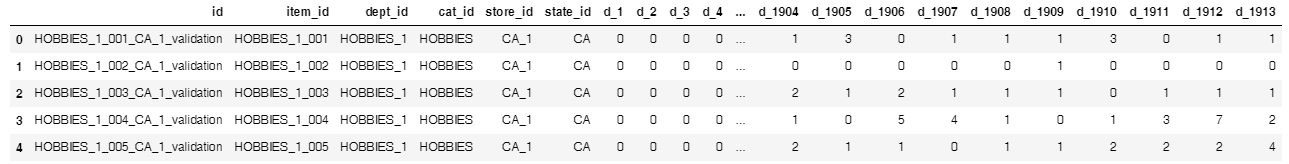

###### (cows are to data as cowboys are to code? hmm...)

A model expects each row that only has variables for one prediction. So, for this particular contest, each row that's fed to a model needs to be an individual product/store/date/etc combination. This requires unpivoting the original data (via pandas' "melt" function) and getting it to look like this:
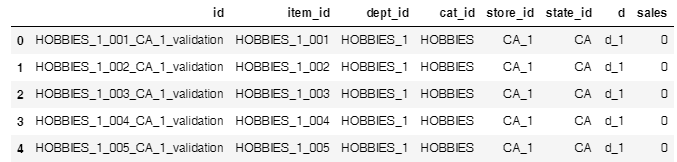

### 2. Do some text manipulation
Maybe just to be slightly more annoying, the column headings for the dates are given in the format of "F#" as opposed to the above historic pricing data of "d_#" ("forecast" instead of "date"), so in order to join the submission predictions to the calendar and pricing data, we'll need to change F# to d_#. Yes, this is just some basic text manipulation, but as I was hacking through this I found it really annoying that they couldn't just keep the date format consistent...

### 3. Make predictions<img src="https://upload.wikimedia.org/wikipedia/commons/c/c1/George_%22Corpsegrinder%22_Fisher_of_Cannibal_Corpse.jpg" align = "right" width = 200> 
After that, we're finally ready to make some predictions. In this notebook, we'll be using an out of the box Random Forest. 

The point of this notebook isn't to build a highly accurate model or to do the other fun/creative stuff of data science (like feature engineering, comparing differnt models, EDA, etc.); **the point of this notebook is to do the unglamorous grunt work so folks can fork it and do fun stuff yourself.**

*(see the picture of a man who knows how to grunt...)*


### 3. Re-pivot and do some text manipulation and make the submission file
The contest requires that the CSV submission file to be in the format as given (see the first picture)... so you have to re-pivot after you've made your predictions to make the final submission file. Yeah, this is more annoying string manipulaiton work...


Ok, enough of my rambling, let's get to the code...

In [ ]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import regex as re
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import gc
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# These helper and data cleaning functions are from the old fast.ai course
# The repository is here: https://github.com/fastai/fastai/tree/master/old
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def make_date(df, date_field:str):
    "Make sure `df[field_name]` is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)
        

def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):
    # add_datepart converts a column of df from a datetime64 to many columns containing the information from the date. 
    # This applies changes inplace.
    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)
        
        
def ifnone (a,b): #(a:Any,b:Any)->Any:
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)


def train_cats(df):    
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)      

#
# End fast.ai funcitons...
#

# This function I believe came from this guy: https://www.kaggle.com/siavrez

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    #return df

In [ ]:
df_cal = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv', parse_dates = ['date'])
df_sales_train = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
df_prices = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')
df_submissions = pd.read_csv('../input/m5-forecasting-accuracy/sample_submission.csv')
df_cal.shape, df_sales_train.shape, df_prices.shape, df_submissions.shape

In [ ]:
# The given format ain't no good for data science...
df_sales_train.head()

In [ ]:
# The format of the submission file is also not good for data science...
df_submissions.head()

# Melt!<img src="https://www.wikihow.com/images/thumb/4/47/Make-a-Crab-Melt-Sandwich-Final.jpg/aid2170143-v4-728px-Make-a-Crab-Melt-Sandwich-Final.jpg.webp" width=200 align = right valign = "top" hspace="20">
The pandas melt method unpivots column values and puts it in rows... i.e. melting creates a row for every day for an item/store combination. Doing this puts the data in a flat format that in a few cells will allow us us to merge the sales training data with the calendar and pricing data sets.

In [ ]:
# Get all columns that aren't day columns
list_id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'] 
df_d_cols = df_sales_train.drop(list_id_vars, axis=1)
df_d_cols.columns

In [ ]:
# This usually takes 16-19 sec to run
%time df_melted_sales = df_sales_train.melt(id_vars = list_id_vars, value_vars = df_d_cols.columns, var_name = 'd', value_name = 'sales') 

In [ ]:
#the resulting melted sales data
df_melted_sales.head()

In [ ]:
# These columns are redundant to id so dropping them.
# This notebook keeps runing into the 16 GB of RAM given in free Kaggle.
# I do a bunch of stuff like this throughout trying to keep the DFs as small as possible.
#df_melted_sales.drop(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis=1, inplace = True) 
df_melted_sales.drop(['item_id', 'dept_id', 'cat_id', 'store_id'], axis=1, inplace = True) 
df_melted_sales.head()

In [ ]:
sub_cols = df_submissions.drop(['id'], axis=1).columns

# Like what we did to the sales data, we also need to melt the submission 
df_melted_sub = df_submissions.melt(id_vars = ['id'], value_vars = sub_cols, 
                                    var_name = 'd', value_name = 'sales') 
df_melted_sub.head()

In [ ]:
df_melted_sub['d'] = df_melted_sub['d'].str.replace('F','')
df_melted_sub.head()

In [ ]:
df_melted_sub['d'] = pd.to_numeric(df_melted_sub['d'], errors='coerce') 
df_melted_sub['d'] = df_melted_sub['d'] + 1913
df_melted_sub = df_melted_sub.applymap(str)
df_melted_sub['d'] = 'd_'+ df_melted_sub['d'].astype(str)
df_melted_sub.head()

In [ ]:
# As per the contest notes, this should end at "d_1941," so that's what we should see here...
df_melted_sub.tail() 

### Free up some RAM
The free Kaggle notebook only gives 16GB of RAM. So we'll delete the initial DFs that were merged into larger DFs and run the "reduce_mem" function on all DFs that we are going to be using in the next section of the notebook.

I do a lot of stuff like this throughout. Obviously, feel free to skip these blocks if you're running this notebook in a more powerful environment.

In [ ]:
%who DataFrame

In [ ]:
del df_sales_train
del df_submissions
del df_d_cols
gc.collect()

In [ ]:
reduce_mem_usage(df_cal)
reduce_mem_usage(df_melted_sales)
reduce_mem_usage(df_melted_sub) 
reduce_mem_usage(df_prices)

# Split!<img src="https://res.cloudinary.com/sagacity/image/upload/c_crop,h_1486,w_2046,x_0,y_0/c_limit,dpr_auto,f_auto,fl_lossy,q_80,w_1080/Screen_Shot_2017-01-18_at_10.04.37_AM_qaaqch.png" align = "right" width = 200>
I'm using a smaller subet of data because it'll be faster to read and predict and to be able to keep it all in the free Kaggle RAM. Note that because this is a time series problem I'm not using scikit-learn train test split. This is because we want to train with older data and test with new data to simulate actual conditions. You will have all historical data, and will try to predict the next few months... Train test split will randomly split the data.



In [ ]:
# I've limited the sample size so we can keep it in RAM in a free Kaggle kernel.
# Only looking at CA only.
# Doing it as an 80/20 split as is standard for train/test.
df_ca_only =  df_melted_sales[df_melted_sales['state_id']=='CA']
df_ca_only.drop(['state_id'], axis=1, inplace = True) 
df_test = df_ca_only.tail(20000) 
df_train = df_ca_only.iloc[-120000:-20000] 
df_submission = df_melted_sub.copy() # Copied just to keep naming conventions consistent
df_ca_only.shape, df_test.shape, df_train.shape, df_submission.shape

In [ ]:
df_train.tail()

In [ ]:
# If this was done right, the number in the id and d columns below should pick up where it left off above
df_test.head() 

# Merge! <img src="https://www.roadtrafficsigns.com/img/md/X/left-lane-merge-sign-x-w4-1l.png" align = "right" width = 200>
Now we'll combine all the reference data to the training and test data into the training and test data frames.

In addition to the standard train/test dfs, we're also going to take the same steps with the submission data.

In [ ]:
# Merge the calendar data with the training, test and submission DFs
df_train = df_train.merge(df_cal, left_on='d', right_on='d', how='left')
df_test = df_test.merge(df_cal, left_on='d', right_on='d', how='left')
df_submission = df_submission.merge(df_cal, left_on='d', right_on='d', how='left')
df_train.shape, df_test.shape, df_submission.shape # should be same numb of cols

In [ ]:
# Because we dropped columns from the training/test/submit DFs, we have to do this to be able to join to prices.
df_prices['id'] = df_prices['item_id'] +'_' + df_prices['store_id']
df_prices.drop(['item_id', 'store_id'], axis=1, inplace = True)
df_prices.head()

In [ ]:
# The training and submission data have a suffix that's not in the price data.
# So here we're creating a column that matches the price id column.
df_train['id_for_price'] = df_train['id'].str.replace('_validation','')
df_test['id_for_price'] = df_test['id'].str.replace('_validation','')
df_submission['id_for_price'] = df_submission['id'].str.replace('_evaluation','')
df_submission['id_for_price'] = df_submission['id_for_price'].str.replace('_validation','')

In [ ]:
# Merge the price data with the training, test and submission DFs
df_train = pd.merge(df_train, df_prices,  how='left', left_on=['id_for_price', 'wm_yr_wk'], 
                    right_on = ['id', 'wm_yr_wk'])
df_test = pd.merge(df_test, df_prices,  how='left', left_on=['id_for_price', 'wm_yr_wk'], 
                   right_on = ['id', 'wm_yr_wk'])
df_submission = pd.merge(df_submission, df_prices,  how='left', left_on=['id_for_price', 'wm_yr_wk'], 
                         right_on = ['id', 'wm_yr_wk'])

# Check to see if there are any missing prices
df_train['sell_price'].count(), df_train.shape, df_test['sell_price'].count(), df_test.shape, df_submission['sell_price'].count(), df_submission.shape

In [ ]:
# Merging with price added a bunch of unneeded columns
df_train.drop(['id_for_price', 'id_y'], axis=1, inplace = True) 
df_train.rename(columns = {"id_x":"id"}, inplace = True)
df_test.drop(['id_for_price', 'id_y'], axis=1, inplace = True) 
df_test.rename(columns = {"id_x":"id"}, inplace = True)
df_submission.drop(['id_for_price', 'id_y'], axis=1, inplace = True) 
df_submission.rename(columns = {"id_x":"id"}, inplace = True)

In [ ]:
%who DataFrame

In [ ]:
# To save some RAM we will get rid of the dataframes that we merged from and are not in use now.
del df_cal
del df_melted_sales
del df_melted_sub
del df_prices
gc.collect()

In [ ]:
reduce_mem_usage(df_train)
reduce_mem_usage(df_test)
reduce_mem_usage(df_submission)

In [ ]:
# Saving the DFs for easy rollback and as a good starting point when reopening the notebook.
# This takes a few minutes...

# I am getting a "halffloat" error with the feather format...
'''
df_train.to_feather('df_train_feather')
df_test.to_feather('df_test_feather')
df_submission.to_feather('df_submissions_feather')'''

# Pickle seems ok though
df_train.to_pickle('df_train_pickle.pkl')
df_test.to_pickle('df_test_pickle.pkl')
df_submission.to_pickle('df_submissions_pickle.pkl')

In [ ]:
# Uncomment to load the pickle files...
#df_train = pd.read_pickle('df_train_pickle.pkl')
#df_test = pd.read_pickle('df_test_pickle.pkl')
#df_submission = pd.read_pickle('df_submissions_pickle.pkl')

# Transform! <img src = "https://upload.wikimedia.org/wikipedia/commons/3/3d/Fesoj_-_Papilio_machaon_%28by%29.jpg" align = "right" width = 200>
So now we'll do some transforms to get all the data in the DFs numeric and remove nulls... i.e. we're putting the data in the format that you need to have the data in for any ML/DL model.

In [ ]:
#cols_with_mmissing = df_merged.columns[df_merged.isnull().any()].tolist()
df_train.columns[df_train.isnull().any()]

In [ ]:
# Before removing nulls we add a boolean column to declare if the value was missing
cols_with_missing = df_train.columns[df_train.isnull().any()].tolist()

for col in cols_with_missing:
    df_train[col + '_was_missing'] = df_train[col].isnull()
    df_test[col + '_was_missing'] = df_test[col].isnull()
    df_submission[col + '_was_missing'] = df_submission[col].isnull()

In [ ]:
imputer_values = {'event_name_1' :'None', 'event_type_1' :'None', 
                  'event_name_2' :'None', 'event_type_2' :'None'                  
                 }
df_train.fillna(value = imputer_values, inplace = True)
df_test.fillna(value = imputer_values, inplace = True)
df_submission.fillna(value = imputer_values, inplace = True)

# Checking to see if there are any missing values
# The no of rows in each DF should be equal to the count
df_train.shape, df_train.count(), df_test.shape, df_test.count(), df_submission.shape, df_submission.count()

In [ ]:
#list of all non-numeric data
df_train.select_dtypes(include = 'object').columns 

In [ ]:
#we're going to use pandas date exploding features, so the given dates will wind up being redundant
drop_fields = ['weekday', 'year', 'wday', 'month']
df_train.drop(drop_fields, axis = 1, inplace = True)
df_test.drop(drop_fields, axis = 1, inplace = True)
df_submission.drop(drop_fields, axis = 1, inplace = True)
df_train.shape, df_test.shape, df_submission.shape

In [ ]:
# The next cell will change the IDs into categorical values.
# But the submission file needs them in the original format, so saving them to a series for use below
df_sub_ids = df_submission['id'].copy()

# We'll need the d column for the submission file format.
# But we can drop it from the train/test dfs as we already have date information in the DF
df_train.drop(['d'], axis = 1, inplace = True)
df_test.drop(['d'], axis = 1, inplace = True)
df_sub_d = df_submission.pop('d')

In [ ]:
# Label encode
# For RAM considerations, we're not going to one hot encode anything.
# These are functions from fast.ai that convert objects to categories and keeps those categories consistent across training and test
train_cats(df_train)
apply_cats(df_test, df_train)
apply_cats(df_submission, df_train)
df_train.shape, df_test.shape, df_submission.shape

# Change categories to numbers
cat_cols = df_train.select_dtypes(include = 'category').columns
for i in cat_cols:
    df_train['cat_'+i] = df_train[i].cat.codes
    df_test['cat_'+i] = df_test[i].cat.codes
    df_submission['cat_'+i] = df_submission[i].cat.codes

df_train.drop(cat_cols, axis = 1, inplace = True)
df_test.drop(cat_cols, axis = 1, inplace = True)
df_submission.drop(cat_cols, axis = 1, inplace = True)

# Should return an empty list
df_train.select_dtypes(include = 'category').columns 

In [ ]:
# Should return an empty list
df_train.select_dtypes(include = 'object').columns

In [ ]:
# Explode out the date column into a ton of columns that a model can use
date_cols = df_train.select_dtypes(include = 'datetime64').columns
for i in date_cols:
    add_datepart(df_train, i)
    add_datepart(df_test, i)
    add_datepart(df_submission, i)

# Should see many more columns at the end of the list (year, month... is_year_end, etc) 
# Should also not see a "date" column
df_train.columns 

In [ ]:
# should only see number and boolean columns
df_train.dtypes 

In [ ]:
reduce_mem_usage(df_train)
reduce_mem_usage(df_test)
reduce_mem_usage(df_submission)

In [ ]:
gc.collect()

In [ ]:
# pickle bookmark to restart from here
df_train.to_pickle('df_train_pickle.pkl')
df_test.to_pickle('df_test_pickle.pkl')
df_submission.to_pickle('df_submissions_pickle.pkl')

# Train and predict! <img src = "https://cdn.ventrata.com/image/upload/ar_1.5,c_fill,dpr_1.0,f_jpg,w_600/v1543512847/puu4dyjmualnnrtppag0.png" align = "right" width = 200>
Ok, finally we're ready to train the model and get some predictions

In [ ]:
# train and test we'll use below, the submission file sales column is all 0's so, we can just get rid of it.
y_train = df_train.pop('sales')
y_test = df_test.pop('sales')
df_submission.drop(['sales'], axis =1, inplace = True)

In [ ]:
# As noted in the intro we're just using an out of the box RF for now.a
m = RandomForestRegressor(n_jobs =-1) 
%time m.fit(df_train, y_train)

In [ ]:
# Scoring in r-squared because it's the default and this is the quick start notebook
# r-squared over 0 means that we're predicting better than if we just predicted the average value
# r-squared of 1 means perfect
# it's a good enough metric to optimize the model on
m.score (df_test, y_test) 

In [ ]:
# For making predictions that we'll submit put train and test together and fit the model again for better predictions
train_test_concat = pd.concat([df_test, df_train])
y_concat = pd.concat([y_test, y_train])
m.fit(train_test_concat, y_concat)

# Scores much better on values it's seen! if only the world were so easy...
m.score (train_test_concat, y_concat)

In [ ]:
df_submission.dtypes

In [ ]:
# And finally, let's make some predictions that we'll submit
predictions = m.predict(df_submission)
predictions

# Make a file and submit it <img src ="https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Letterbox_Bourdon.jpg/800px-Letterbox_Bourdon.jpg" align = "right" width= 200>
So, now that we have our predictions, we need to get the submission file in the format that is required by the contest.

In [ ]:
# Add the predictions made above and the original ids back onto the dataframe
df_submission['sales'] = predictions
df_submission['id'] = df_sub_ids
df_submission['F'] = df_sub_d

In [ ]:
d = {'id': df_sub_ids,'F': df_sub_d, 'preds': predictions}
sub_file = pd.DataFrame(data=d)
sub_file.head()

In [ ]:
# As per the competition requirements, we have to change the "d" values to F values
sub_file['F'] = sub_file['F'].str.replace('d_','')
sub_file['F'] = pd.to_numeric(sub_file['F'], errors='coerce') 
sub_file['F'] = sub_file['F'] - 1913
sub_file['F'] = 'F'+ sub_file['F'].astype(str)
sub_file.head()

In [ ]:
# Pivot and reset the index to flatten the file
sub_file = sub_file.pivot(index='id', columns='F', values='preds')
sub_file = sub_file.reset_index()
sub_file.head()

In [ ]:
# And finally... we have our submisison file...
csv_submit = sub_file.to_csv('submission.csv', index = False)